# November 5th, 2021

**Motivation**: Take a look at fft, calculate correlations within certain band (toward the end) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy import fft as sp_fft

## fs = 1

In [3]:
fs = 1
delta_t = 1 / fs
N = 600
t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(1, 1.0)

In [4]:
f1 = 0.25
omega1 = 2 * np.pi * f1
x1 = np.sin(omega1 * time)

f2 = 0.05
omega2 = 2 * np.pi * f2
x2 = np.sin(omega2 * time)

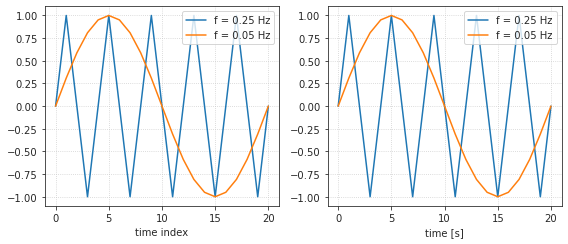

In [5]:
fig, axes = create_figure(1, 2, (8, 3.5))
intvl = range(0, fs * int(5 / f1) + 1)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [6]:
y1 = sp_fft.fft(x1, norm='forward')
y2 = sp_fft.fft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

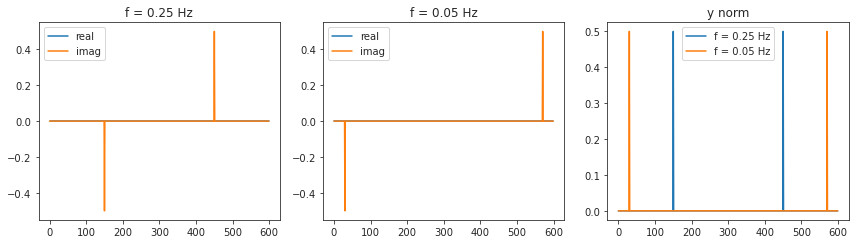

In [7]:
fig, axes = create_figure(1, 3, (12, 3.5))

for ax, (_y, _y_norm, _f) in zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)]):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"f = {_f} Hz")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [8]:
np.where(y1_norm > 1e-5)[0], np.where(y2_norm > 1e-5)[0]

(array([150, 450]), array([ 30, 570]))

In [9]:
150 / N, 30 / N

(0.25, 0.05)

In [10]:
f1, f2

(0.25, 0.05)

In [11]:
1 / 600, 300 / 600

(0.0016666666666666668, 0.5)

In [16]:
freqs = sp_fft.rfftfreq(len(t_idxs), 1/fs)
len(freqs)

301

In [17]:
freqs

array([0.        , 0.00166667, 0.00333333, 0.005     , 0.00666667,
       0.00833333, 0.01      , 0.01166667, 0.01333333, 0.015     ,
       0.01666667, 0.01833333, 0.02      , 0.02166667, 0.02333333,
       0.025     , 0.02666667, 0.02833333, 0.03      , 0.03166667,
       0.03333333, 0.035     , 0.03666667, 0.03833333, 0.04      ,
       0.04166667, 0.04333333, 0.045     , 0.04666667, 0.04833333,
       0.05      , 0.05166667, 0.05333333, 0.055     , 0.05666667,
       0.05833333, 0.06      , 0.06166667, 0.06333333, 0.065     ,
       0.06666667, 0.06833333, 0.07      , 0.07166667, 0.07333333,
       0.075     , 0.07666667, 0.07833333, 0.08      , 0.08166667,
       0.08333333, 0.085     , 0.08666667, 0.08833333, 0.09      ,
       0.09166667, 0.09333333, 0.095     , 0.09666667, 0.09833333,
       0.1       , 0.10166667, 0.10333333, 0.105     , 0.10666667,
       0.10833333, 0.11      , 0.11166667, 0.11333333, 0.115     ,
       0.11666667, 0.11833333, 0.12      , 0.12166667, 0.12333333,
       0.125     , 0.12666667, 0.12833333, 0.13      , 0.13166667,
       0.13333333, 0.135     , 0.13666667, 0.13833333, 0.14      ,
       0.14166667, 0.14333333, 0.145     , 0.14666667, 0.14833333,
       0.15      , 0.15166667, 0.15333333, 0.155     , 0.15666667,
       0.15833333, 0.16      , 0.16166667, 0.16333333, 0.165     ,
       0.16666667, 0.16833333, 0.17      , 0.17166667, 0.17333333,
       0.175     , 0.17666667, 0.17833333, 0.18      , 0.18166667,
       0.18333333, 0.185     , 0.18666667, 0.18833333, 0.19      ,
       0.19166667, 0.19333333, 0.195     , 0.19666667, 0.19833333,
       0.2       , 0.20166667, 0.20333333, 0.205     , 0.20666667,
       0.20833333, 0.21      , 0.21166667, 0.21333333, 0.215     ,
       0.21666667, 0.21833333, 0.22      , 0.22166667, 0.22333333,
       0.225     , 0.22666667, 0.22833333, 0.23      , 0.23166667,
       0.23333333, 0.235     , 0.23666667, 0.23833333, 0.24      ,
       0.24166667, 0.24333333, 0.245     , 0.24666667, 0.24833333,
       0.25      , 0.25166667, 0.25333333, 0.255     , 0.25666667,
       0.25833333, 0.26      , 0.26166667, 0.26333333, 0.265     ,
       0.26666667, 0.26833333, 0.27      , 0.27166667, 0.27333333,
       0.275     , 0.27666667, 0.27833333, 0.28      , 0.28166667,
       0.28333333, 0.285     , 0.28666667, 0.28833333, 0.29      ,
       0.29166667, 0.29333333, 0.295     , 0.29666667, 0.29833333,
       0.3       , 0.30166667, 0.30333333, 0.305     , 0.30666667,
       0.30833333, 0.31      , 0.31166667, 0.31333333, 0.315     ,
       0.31666667, 0.31833333, 0.32      , 0.32166667, 0.32333333,
       0.325     , 0.32666667, 0.32833333, 0.33      , 0.33166667,
       0.33333333, 0.335     , 0.33666667, 0.33833333, 0.34      ,
       0.34166667, 0.34333333, 0.345     , 0.34666667, 0.34833333,
       0.35      , 0.35166667, 0.35333333, 0.355     , 0.35666667,
       0.35833333, 0.36      , 0.36166667, 0.36333333, 0.365     ,
       0.36666667, 0.36833333, 0.37      , 0.37166667, 0.37333333,
       0.375     , 0.37666667, 0.37833333, 0.38      , 0.38166667,
       0.38333333, 0.385     , 0.38666667, 0.38833333, 0.39      ,
       0.39166667, 0.39333333, 0.395     , 0.39666667, 0.39833333,
       0.4       , 0.40166667, 0.40333333, 0.405     , 0.40666667,
       0.40833333, 0.41      , 0.41166667, 0.41333333, 0.415     ,
       0.41666667, 0.41833333, 0.42      , 0.42166667, 0.42333333,
       0.425     , 0.42666667, 0.42833333, 0.43      , 0.43166667,
       0.43333333, 0.435     , 0.43666667, 0.43833333, 0.44      ,
       0.44166667, 0.44333333, 0.445     , 0.44666667, 0.44833333,
       0.45      , 0.45166667, 0.45333333, 0.455     , 0.45666667,
       0.45833333, 0.46      , 0.46166667, 0.46333333, 0.465     ,
       0.46666667, 0.46833333, 0.47      , 0.47166667, 0.47333333,
       0.475     , 0.47666667, 0.47833333, 0.48      , 0.48166667,
       0.48333333, 0.485     , 0.48666667, 0.48833333, 0.49      ,
       0.49166667, 0.49333333, 0.495     , 0.49

## fs = 10

In [18]:
fs = 10
delta_t = 1 / fs
N = 600
t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [19]:
f1 = 2.5
omega1 = 2 * np.pi * f1
x1 = np.sin(omega1 * time)

f2 = 0.5
omega2 = 2 * np.pi * f2
x2 = np.sin(omega2 * time)

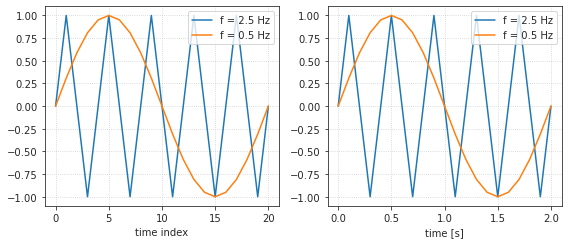

In [20]:
fig, axes = create_figure(1, 2, (8, 3.5))
intvl = range(0, fs * int(5 / f1) + 1)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [22]:
y1 = sp_fft.fft(x1, norm='forward')
y2 = sp_fft.fft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

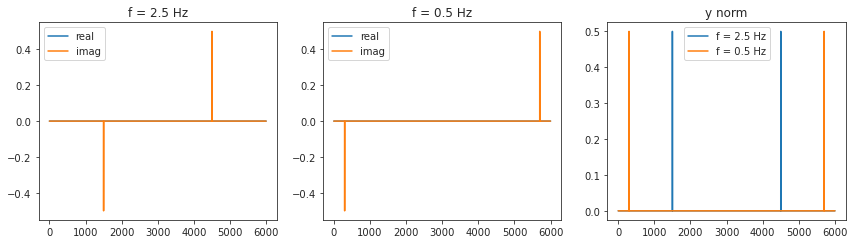

In [23]:
fig, axes = create_figure(1, 3, (12, 3.5))

for ax, (_y, _y_norm, _f) in zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)]):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"f = {_f} Hz")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [24]:
np.where(y1_norm > 1e-5)[0], np.where(y2_norm > 1e-5)[0]

(array([1500, 4500]), array([ 300, 5700]))

In [25]:
1500 / N, 300 / N

(2.5, 0.5)

In [26]:
f1, f2

(2.5, 0.5)

In [27]:
1 / 600, 3000 / 600

(0.0016666666666666668, 5.0)

In [30]:
freqs = sp_fft.rfftfreq(len(t_idxs), 1/fs)
len(freqs)

3001

In [31]:
freqs

array([0.00000000e+00, 1.66666667e-03, 3.33333333e-03, ...,
       4.99666667e+00, 4.99833333e+00, 5.00000000e+00])

In [33]:
freqs[1500], freqs[300]

(2.5, 0.5)

## fs = 10, with constant term

In [38]:
N = 600
fs = 10
delta_t = 1 / fs

t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [39]:
f1 = 2.5
omega1 = 2 * np.pi * f1
x1 = np.sin(omega1 * time)

f2 = 0.5
omega2 = 2 * np.pi * f2
x2 = np.sin(omega2 * time) + 1

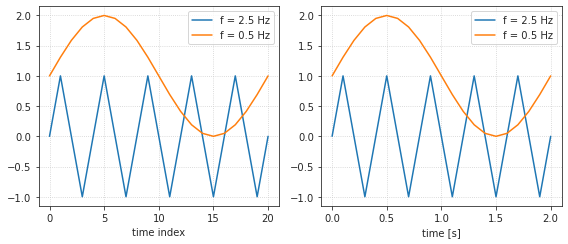

In [40]:
fig, axes = create_figure(1, 2, (8, 3.5))
intvl = range(0, fs * int(5 / f1) + 1)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [41]:
y1 = sp_fft.fft(x1, norm='forward')
y2 = sp_fft.fft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

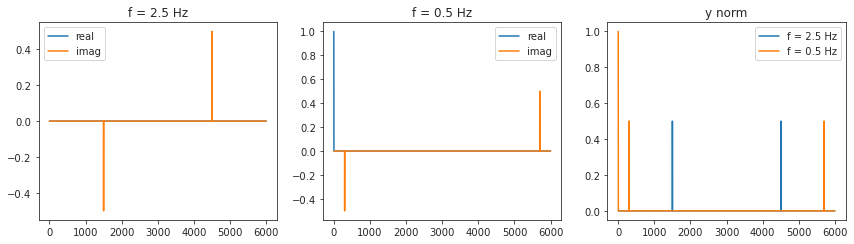

In [42]:
fig, axes = create_figure(1, 3, (12, 3.5))

for ax, (_y, _y_norm, _f) in zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)]):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"f = {_f} Hz")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [43]:
np.where(y1_norm > 1e-5)[0], np.where(y2_norm > 1e-5)[0]

(array([1500, 4500]), array([   0,  300, 5700]))

## Random noise

In [44]:
N = 600
fs = 10
delta_t = 1 / fs

t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [108]:
rng = get_rng(42)

mean = np.zeros(2)
cov = np.ones((2, 2))
cov[0, 1] = 0.5
cov[1, 0] = 0.5

data = rng.multivariate_normal(mean, cov, size=len(time))
x1, x2 = data.T
x1.shape, x2.shape

((6000,), (6000,))

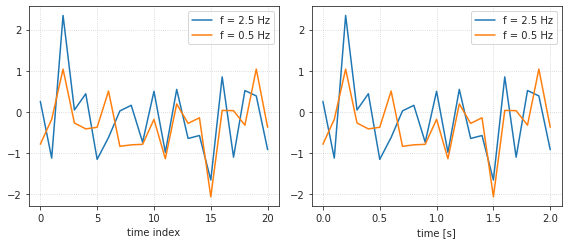

In [109]:
fig, axes = create_figure(1, 2, (8, 3.5))
intvl = range(0, fs * int(5 / f1) + 1)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [110]:
y1 = sp_fft.fft(x1, norm='forward')
y2 = sp_fft.fft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

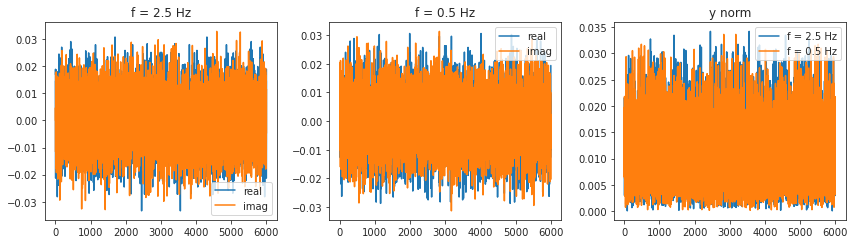

In [111]:
fig, axes = create_figure(1, 3, (12, 3.5))

for ax, (_y, _y_norm, _f) in zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)]):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"f = {_f} Hz")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [258]:
y1_norm.std()

0.006112301430339091

In [112]:
m = 1000
y1.real[1000], y1.imag[1000]

(-0.005929458503375431, 0.007143703961935802)

In [113]:
c = y1.conj() * y2

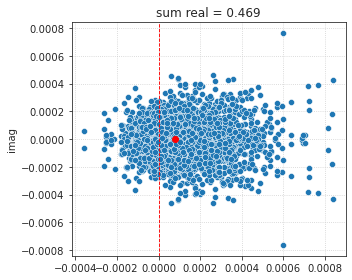

In [114]:
fig, ax = create_figure(1, 1, (5, 4))

sns.scatterplot(x=c.real, y=c.imag, ax=ax)
ax.set_ylabel('real')
ax.set_ylabel('imag')
ax.grid()

ax.plot(c.mean().real, c.mean().imag, marker='o', color='r')
ax.axvline(0, color='r', ls='--', lw=0.9)
ax.set_title(f"sum real = {c.sum().real:0.3f}")

plt.show()

In [115]:
sp_stats.pearsonr(x1, x2)

(0.47269905568406434, 0.0)

In [116]:
c.shape

(6000,)

In [234]:
band = range(300, 900)

In [235]:
freqs[band]

array([0.5       , 0.50166667, 0.50333333, 0.505     , 0.50666667,
       0.50833333, 0.51      , 0.51166667, 0.51333333, 0.515     ,
       0.51666667, 0.51833333, 0.52      , 0.52166667, 0.52333333,
       0.525     , 0.52666667, 0.52833333, 0.53      , 0.53166667,
       0.53333333, 0.535     , 0.53666667, 0.53833333, 0.54      ,
       0.54166667, 0.54333333, 0.545     , 0.54666667, 0.54833333,
       0.55      , 0.55166667, 0.55333333, 0.555     , 0.55666667,
       0.55833333, 0.56      , 0.56166667, 0.56333333, 0.565     ,
       0.56666667, 0.56833333, 0.57      , 0.57166667, 0.57333333,
       0.575     , 0.57666667, 0.57833333, 0.58      , 0.58166667,
       0.58333333, 0.585     , 0.58666667, 0.58833333, 0.59      ,
       0.59166667, 0.59333333, 0.595     , 0.59666667, 0.59833333,
       0.6       , 0.60166667, 0.60333333, 0.605     , 0.60666667,
       0.60833333, 0.61      , 0.61166667, 0.61333333, 0.615     ,
       0.61666667, 0.61833333, 0.62      , 0.62166667, 0.62333333,
       0.625     , 0.62666667, 0.62833333, 0.63      , 0.63166667,
       0.63333333, 0.635     , 0.63666667, 0.63833333, 0.64      ,
       0.64166667, 0.64333333, 0.645     , 0.64666667, 0.64833333,
       0.65      , 0.65166667, 0.65333333, 0.655     , 0.65666667,
       0.65833333, 0.66      , 0.66166667, 0.66333333, 0.665     ,
       0.66666667, 0.66833333, 0.67      , 0.67166667, 0.67333333,
       0.675     , 0.67666667, 0.67833333, 0.68      , 0.68166667,
       0.68333333, 0.685     , 0.68666667, 0.68833333, 0.69      ,
       0.69166667, 0.69333333, 0.695     , 0.69666667, 0.69833333,
       0.7       , 0.70166667, 0.70333333, 0.705     , 0.70666667,
       0.70833333, 0.71      , 0.71166667, 0.71333333, 0.715     ,
       0.71666667, 0.71833333, 0.72      , 0.72166667, 0.72333333,
       0.725     , 0.72666667, 0.72833333, 0.73      , 0.73166667,
       0.73333333, 0.735     , 0.73666667, 0.73833333, 0.74      ,
       0.74166667, 0.74333333, 0.745     , 0.74666667, 0.74833333,
       0.75      , 0.75166667, 0.75333333, 0.755     , 0.75666667,
       0.75833333, 0.76      , 0.76166667, 0.76333333, 0.765     ,
       0.76666667, 0.76833333, 0.77      , 0.77166667, 0.77333333,
       0.775     , 0.77666667, 0.77833333, 0.78      , 0.78166667,
       0.78333333, 0.785     , 0.78666667, 0.78833333, 0.79      ,
       0.79166667, 0.79333333, 0.795     , 0.79666667, 0.79833333,
       0.8       , 0.80166667, 0.80333333, 0.805     , 0.80666667,
       0.80833333, 0.81      , 0.81166667, 0.81333333, 0.815     ,
       0.81666667, 0.81833333, 0.82      , 0.82166667, 0.82333333,
       0.825     , 0.82666667, 0.82833333, 0.83      , 0.83166667,
       0.83333333, 0.835     , 0.83666667, 0.83833333, 0.84      ,
       0.84166667, 0.84333333, 0.845     , 0.84666667, 0.84833333,
       0.85      , 0.85166667, 0.85333333, 0.855     , 0.85666667,
       0.85833333, 0.86      , 0.86166667, 0.86333333, 0.865     ,
       0.86666667, 0.86833333, 0.87      , 0.87166667, 0.87333333,
       0.875     , 0.87666667, 0.87833333, 0.88      , 0.88166667,
       0.88333333, 0.885     , 0.88666667, 0.88833333, 0.89      ,
       0.89166667, 0.89333333, 0.895     , 0.89666667, 0.89833333,
       0.9       , 0.90166667, 0.90333333, 0.905     , 0.90666667,
       0.90833333, 0.91      , 0.91166667, 0.91333333, 0.915     ,
       0.91666667, 0.91833333, 0.92      , 0.92166667, 0.92333333,
       0.925     , 0.92666667, 0.92833333, 0.93      , 0.93166667,
       0.93333333, 0.935     , 0.93666667, 0.93833333, 0.94      ,
       0.94166667, 0.94333333, 0.945     , 0.94666667, 0.94833333,
       0.95      , 0.95166667, 0.95333333, 0.955     , 0.95666667,
       0.95833333, 0.96      , 0.96166667, 0.96333333, 0.965     ,
       0.96666667, 0.96833333, 0.97      , 0.97166667, 0.97333333,
       0.975     , 0.97666667, 0.97833333, 0.98      , 0.98166667,
       0.98333333, 0.985     , 0.98666667, 0.98833333, 0.99      ,
       0.99166667, 0.99333333, 0.995     , 0.99

In [260]:
def mk_complex_arr(rng, loc=0.0, scale=1.0, size=None):
    a = rng.normal(loc, scale, size=size)
    b = rng.normal(loc, scale, size=size)
    c = np.array(a, dtype=complex)
    c.imag = b
    return c

In [261]:
y1_syn = mk_complex_arr(rng, loc=0.0, scale=0.005, size=len(time))
y2_syn = mk_complex_arr(rng, loc=0.0, scale=0.005, size=len(time))

[<matplotlib.lines.Line2D object at 0x7f397c55c280>]

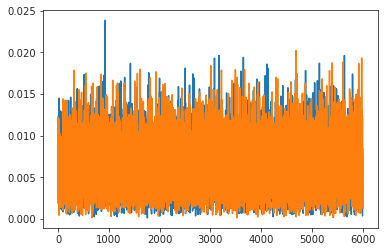

In [262]:
plt.plot(np.linalg.norm(y1_syn.reshape(1, -1), ord=2, axis=0))
plt.plot(np.linalg.norm(y2_syn.reshape(1, -1), ord=2, axis=0))

In [263]:
band

range(300, 900)

In [264]:
band_comp = range(len(time) - band.stop, len(time) - band.start)
band_comp

range(5100, 5700)

In [265]:
y2_syn[band] = y1_syn[band]
y2_syn[band_comp] = y1_syn[band_comp]

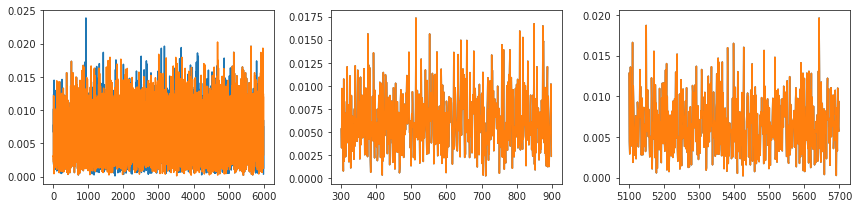

In [266]:
fig, axes = create_figure(1, 3, (12, 3))

axes[0].plot(np.linalg.norm(y1_syn.reshape(1, -1), ord=2, axis=0))
axes[0].plot(np.linalg.norm(y2_syn.reshape(1, -1), ord=2, axis=0))

axes[1].plot(band, np.linalg.norm(y1_syn.reshape(1, -1), ord=2, axis=0).squeeze()[band])
axes[1].plot(band, np.linalg.norm(y2_syn.reshape(1, -1), ord=2, axis=0).squeeze()[band])

axes[2].plot(band_comp, np.linalg.norm(y1_syn.reshape(1, -1), ord=2, axis=0).squeeze()[band_comp])
axes[2].plot(band_comp, np.linalg.norm(y2_syn.reshape(1, -1), ord=2, axis=0).squeeze()[band_comp])

plt.show()

In [270]:
x1_syn = sp_fft.ifft(y1_syn, norm='forward')
x2_syn = sp_fft.ifft(y2_syn, norm='forward')

x1_syn.shape, x2_syn.shape

((6000,), (6000,))

In [273]:
x1_syn

array([-0.68532058-0.71792913j, -0.02243783-0.30546783j,
        0.1134459 -0.63989106j, ...,  0.81655599+0.29992883j,
       -0.10194799+0.25230143j, -0.33317575+0.01762643j])

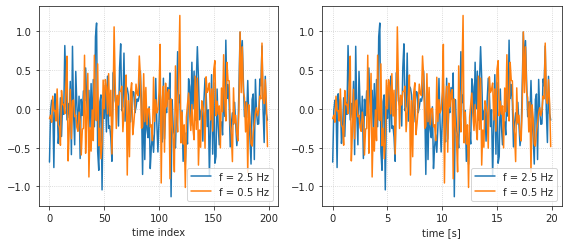

In [275]:
fig, axes = create_figure(1, 2, (8, 3.5))
intvl = range(0, 200)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1_syn.real[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2_syn.real[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [288]:
sp_stats.pearsonr(x1_syn.imag, x2_syn.imag)

(0.20254731464393294, 1.3938062638673305e-56)

In [289]:
sp_stats.pearsonr(x1_syn.real, x2_syn.real)

(0.21064532187156626, 3.7573243855653924e-61)

In [290]:
sp_stats.pearsonr(x1_syn, x2_syn)

((0.005116187813774849-0.008554011069151877j), 0.6919440462719688)

In [292]:
x1_norm = np.linalg.norm(x1_syn.reshape(1, -1), ord=2, axis=0).squeeze()
x2_norm = np.linalg.norm(x2_syn.reshape(1, -1), ord=2, axis=0).squeeze()

sp_stats.pearsonr(x1_norm, x2_norm)

(0.04864580876103461, 0.000163552174523038)

In [ ]:
x1_syn = 0.7 * np.sin()

In [293]:
y1 = sp_fft.fft(x1_syn, norm='forward')
y2 = sp_fft.fft(x2_syn, norm='forward')

In [294]:
c = y1.conj() * y2

In [295]:
c.sum()

(0.062290089428156066-0.0011898853621892665j)

In [296]:
c[band].sum()

(0.029898239631533333-3.0094815918149274e-19j)

In [297]:
c[band_comp].sum()

(0.031431125311793824-2.252065392124622e-19j)

## try again

In [371]:
N = 600
fs = 10
delta_t = 1 / fs

t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [372]:
freqs = sp_fft.rfftfreq(len(t_idxs), 1/fs)
len(freqs)

3001

In [392]:
f1 = 2.5
f2 = 0.5
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

x1 = 0.8 * np.sin(omega1 * time) - 0.4 * np.sin(omega2 * time)
x2 = 0.8 * np.sin(omega1 * time) + 0.4 * np.sin(omega2 * time)

x1 = sp_stats.zscore(x1)
x2 = sp_stats.zscore(x2)

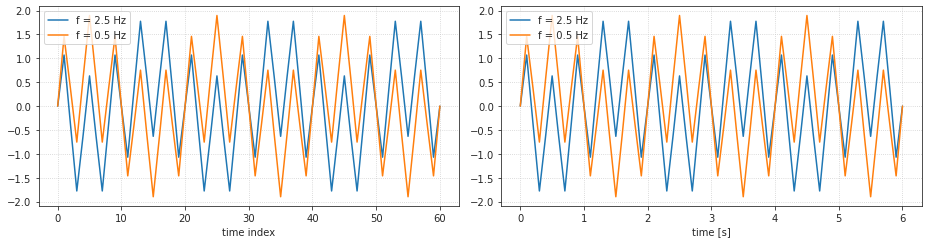

In [393]:
fig, axes = create_figure(1, 2, (13., 3.5))
intvl = range(0, fs * int(15 / f1) + 1)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [394]:
x1.mean(), x2.mean()

(1.1842378929335004e-17, -3.315866100213801e-17)

In [395]:
x1.std(), x2.std()

(1.0, 1.0)

In [396]:
sp_stats.pearsonr(x1, x2)

(0.6000000000000002, 0.0)

In [397]:
y1 = sp_fft.fft(x1, norm='forward')
y2 = sp_fft.fft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

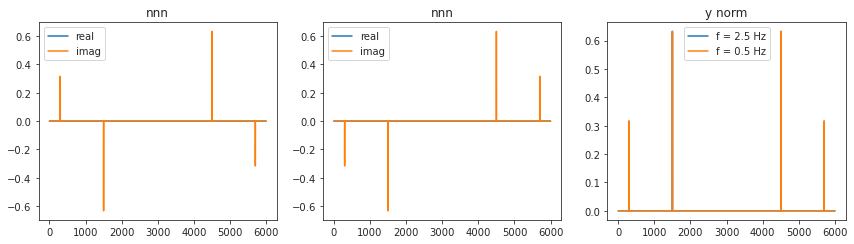

In [398]:
fig, axes = create_figure(1, 3, (12, 3.5))

for ax, (_y, _y_norm, _f) in zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)]):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title('nnn')
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

(-0.1, 0.1)

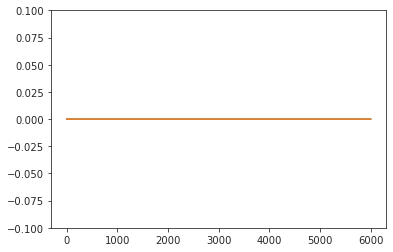

In [399]:
plt.plot(y1.real)
plt.plot(y2.real)
plt.ylim(-0.1, 0.1)

In [400]:
c = y1.conj() * y2
c.sum()

(0.6000000000000002+6.310887241768095e-30j)

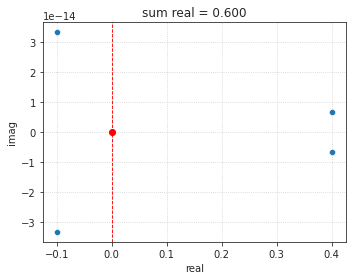

In [401]:
fig, ax = create_figure(1, 1, (5, 4))

sns.scatterplot(x=c.real, y=c.imag, ax=ax)
ax.set_xlabel('real')
ax.set_ylabel('imag')
ax.grid()

ax.plot(c.mean().real, c.mean().imag, marker='o', color='r')
ax.axvline(0, color='r', ls='--', lw=0.9)
ax.set_title(f"sum real = {c.sum().real:0.3f}")

plt.show()

In [402]:
np.argmin(np.abs(freqs - 2.5))

1500

In [403]:
freqs[1500]

2.5

In [404]:
band_fw = range(1499, 1502)
band_bw = range(len(time) - band_fw.stop + 1, len(time) - band_fw.start + 1)
band = list(itertools.chain(band_fw, band_bw))
band

[1499, 1500, 1501, 4499, 4500, 4501]

In [405]:
c[band].sum()

(0.8000000000000002+2.307306504822552e-31j)

In [406]:
np.argmin(np.abs(freqs - 0.5))

300

In [407]:
freqs[300]

0.5

In [408]:
band_fw = range(299, 302)
band_bw = range(len(time) - band_fw.stop + 1, len(time) - band_fw.start + 1)
band = list(itertools.chain(band_fw, band_bw))
band

[299, 300, 301, 5699, 5700, 5701]

In [409]:
c[band].sum()

(-0.19999999999999993+3.0581819962008096e-30j)

## tsBNgen

In [139]:
from tsBNgen.tsBNgen import tsBNgen

In [206]:
T=6000
N=3
N_level=[2,2,2]
Mat=pd.DataFrame(np.array(([0,1,1,1,1],[0,0,1,1,1],[0,0,0,1,1],[0,0,0,0,0],[0,0,0,0,0]))) 
Node_Type=['D','D','D','C','C']

CPD={'0':[0.6,.04],'01':[[0.7,0.3],[0.3,0.7]],'012':[[0.9,0.1],[0.4,0.6],[0.6,0.4],[0.1,0.9]],
   '0123':{'mu0':5,'sigma0':2,'mu1':10,'sigma1':3,'mu2':20,'sigma2':2,'mu3':50,'sigma3':3,'mu4':20,'sigma4':2,'mu5':40,'sigma5':3,'mu6':50,'sigma6':5,'mu7':80,'sigma7':3,
          },'0124':{'mu0':500,'sigma0':10,'mu1':480,'sigma1':13,'mu2':450,'sigma2':10,'mu3':400,'sigma3':13,'mu4':400,'sigma4':10,'mu5':300,'sigma5':10,'mu6':250,'sigma6':10,'mu7':100,'sigma7':5}}

Parent={'0':[],'1':[0],'2':[0,1],'3':[0,1,2],'4':[0,1,2]}

CPD2={'00':[[0.6,0.4],[0.2,0.8]],'011':[[0.8,0.2],[0.6,0.4],[0.7,0.3],[0.2,0.8]],
      '0122':[[0.9,0.1],[0.7,0.3],[0.7,0.3],[0.28,0.78],[0.7,0.3],[0.28,0.72],[0.28,0.72],[0.1,0.9]],'01233':{'33':{'coefficient':[np.linspace(0.6,0.8,8).tolist()]},'sigma_intercept':np.linspace(0.6,3,8).tolist(),'sigma':np.linspace(3,4,8).tolist()},'01244':{'44':{'coefficient':[np.linspace(0.6,1.3,8).tolist()]},
    'sigma_intercept':np.linspace(2,5,8).tolist(),'sigma':np.linspace(3,4,8).tolist()}}

loopbacks={'00':[1],'11':[1],'22':[1],'33':[1],'44':[1]}  

Parent2={'0':[0],'1':[0,1],'2':[0,1,2],'3':[0,1,2,3],'4':[0,1,2,4]}


Time_series4=tsBNgen(T,N,N_level,Mat,Node_Type,CPD,Parent,CPD2,Parent2,loopbacks)

Time_series4.BN_data_gen()

In [189]:
list(Time_series4.BN_Nodes)

[0, 1, 2, 3, 4]

[<matplotlib.lines.Line2D object at 0x7f39821546a0>]

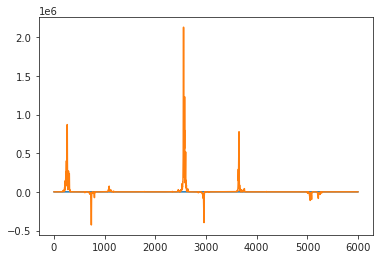

In [198]:
plt.plot(Time_series4.BN_Nodes[3][1])
plt.plot(Time_series4.BN_Nodes[4][1])

In [202]:
sp_stats.pearsonr(Time_series4.BN_Nodes[3][1], Time_series4.BN_Nodes[4][1])

(0.03580393339870609, 0.00554275024190357)

In [203]:
Mat

,0,1,2,3,4
0,0,1,1,1,1
1,0,0,1,1,1
2,0,0,0,1,1
3,0,0,0,0,0
4,0,0,0,0,0
